In [9]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "./"
FILE_PATH = ""
FILE_URL = DOWNLOAD_ROOT + FILE_PATH + "/data.tgz"

def fetch_data(file_url=FILE_URL, file_path=FILE_PATH):
    if not os.path.isdir(file_path):
        os.makedirs(file_path)
    tgz_path = os.path.join(file_path, "data.tgz")
    urllib.request.urlretrieve(file_url, tgz_path)
    data_tgz = tarfile.open(tgz_path)
    data_tgz.extractall(path=file_path)
    data_tgz.close()

In [125]:
import pandas as pd
import numpy as np

def load_data(file_path = FILE_PATH):
    csv_path = os.path.join(file_path, "data.csv")
    return pd.read_csv(csv_path)

In [114]:
origdata = load_data()
data = origdata.drop("race/ethnicity", axis=1)
data.head()

,id,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,1,female,bachelor's degree,standard,none,72,72,74
1,2,female,some college,standard,completed,69,90,88
2,3,female,master's degree,standard,none,90,95,93
3,4,male,associate's degree,free/reduced,none,47,57,44
4,5,male,some college,standard,none,76,78,75


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
id                             1000 non-null int64
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [26]:
data["lunch"].value_counts()

standard        645
free/reduced    355
Name: lunch, dtype: int64

In [15]:
data["test preparation course"].value_counts()

none         642
completed    358
Name: test preparation course, dtype: int64

In [87]:
data["parental level of education"].value_counts()

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64

In [101]:
data.describe()

,id,math score,reading score,writing score
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,66.08900,69.169000,68.054000
std,288.819436,15.16308,14.600192,15.195657
min,1.000000,0.00000,17.000000,10.000000
25%,250.750000,57.00000,59.000000,57.750000
50%,500.500000,66.00000,70.000000,69.000000
75%,750.250000,77.00000,79.000000,79.000000
max,1000.000000,100.00000,100.000000,100.000000


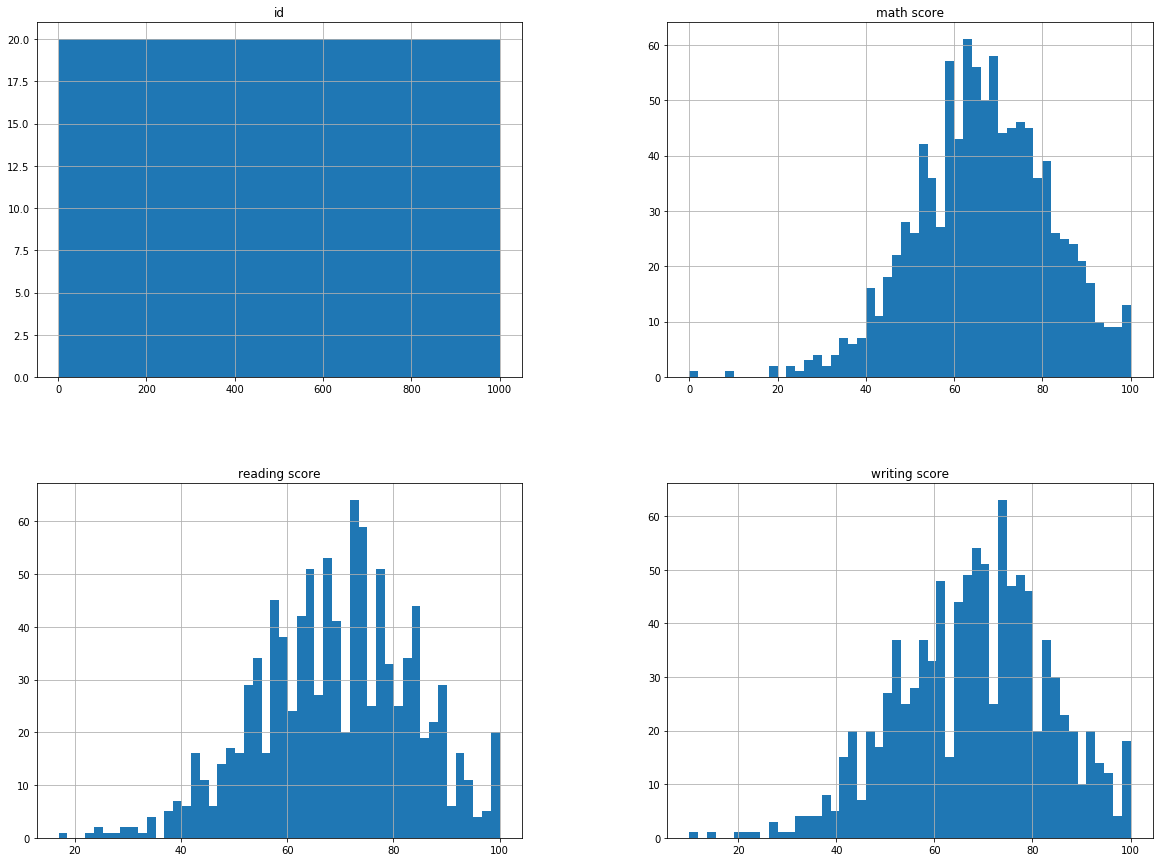

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [115]:
# Choose test set based on stratifying b/t lunch and no lunch:

# from sklearn.model_selection import StratifiedShuffleSplit

# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# for trainidx, testidx in split.split(data, data["lunch"]):
#     strat_train_set = data.loc(trainidx)
#     strat_test_set = data.loc(testidx)

# SRS will work just as well on this data:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [116]:
corr_matrix = data.corr()
corr_matrix["math score"].sort_values(ascending=False)

math score       1.000000
reading score    0.817580
writing score    0.802642
id               0.036827
Name: math score, dtype: float64

In [117]:
data = train_set.drop("math score", axis=1)
data_labels = train_set["math score"].copy()

In [118]:
from sklearn.preprocessing import LabelBinarizer

def encode_cats(data):
    encoder = LabelBinarizer()
    data_lunch_cat = data["lunch"]
    data_parent_cat = data["parental level of education"]
    data_testprep_cat = data["test preparation course"]
    data_gender_cat = data["gender"]
#     data_eth_cat = data["race/ethnicity"]

    lunch_1hot = encoder.fit_transform(data_lunch_cat)
    parent_1hot = encoder.fit_transform(data_parent_cat)
    testprep_1hot = encoder.fit_transform(data_testprep_cat)
    gender_1hot = encoder.fit_transform(data_gender_cat)
#     eth_1hot = encoder.fit_transform(data_eth_cat)
    
    data["lunch"] = lunch_1hot
    data["parental level of education"] = parent_1hot
    data["test preparation course"] = testprep_1hot
    data["gender"] = gender_1hot
#     data["race/ethnicity"] = eth_1hot
    
    return data

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

def prepareData(somedata):
#     cat_attribs = [["lunch"], ["parental level of education"], ["test preparation course"], ["gender"], ["race/ethnicity"]]    

#     for cat_attrib in cat_attribs:
#         cat_pipeline = Pipeline([
#             ('selector', DataFrameSelector(cat_attrib)),
#             ('label_binarizer', LabelBinarizerPipelineFriendly()),
#         ])
#         data_prepared = cat_pipeline.fit_transform(somedata)
    data_prepared = encode_cats(somedata)
    
    return data_prepared

data_prepared = prepareData(data)
data_prepared.shape

data_prepared
# num_pipeline if needed here
# is there a way to perform encode_cats() using this pipeline instead?
    

# encode_cats()



,id,gender,parental level of education,lunch,test preparation course,reading score,writing score
29,30,0,0,1,1,70,75
535,536,0,0,0,0,83,83
695,696,0,0,0,1,89,86
557,558,1,0,0,1,67,66
836,837,1,0,1,1,64,57
...,...,...,...,...,...,...,...
106,107,0,0,1,1,100,100
270,271,1,0,1,1,63,61
860,861,0,1,1,1,62,53
435,436,1,0,0,0,48,53


In [120]:
# Selecting and Training the Model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(data_prepared, data_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [123]:
some_data = data.iloc[:5]
some_labels = data_labels.iloc[:5]
some_data_prepared = prepareData(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t", list(some_labels))

Predictions:	 [66.66516592 69.67976367 76.47108231 69.58783842 66.83714105]
Labels:	 [62, 66, 79, 61, 73]


c:\users\odror\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\odror\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\odror\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [126]:
from sklearn.metrics import mean_squared_error

data_predictions = lin_reg.predict(data_prepared)
lin_mse = mean_squared_error(data_labels, data_predictions)
linrmse = np.sqrt(lin_mse)
print(linrmse)

5.670448517340296
